<a href="https://colab.research.google.com/github/youssef893/detect-handwritten-english-letter/blob/main/detect_handwritten_english_letter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install emnist

In [17]:
from emnist import extract_training_samples, extract_test_samples
from sklearn.utils import shuffle
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data


In [18]:
x_train, y_train = extract_training_samples('letters')
x_test, y_test = extract_test_samples('letters')

# Preprocess Data

In [19]:
x_train.shape

(124800, 28, 28)

In [20]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [21]:
x_train, y_train = shuffle(x_train, y_train, random_state=15)

In [22]:
x_train.shape, y_train.shape

((124800, 28, 28, 1), (124800,))

In [23]:
y_train = to_categorical(y_train, num_classes=27)
y_test = to_categorical(y_test, num_classes=27)

In [24]:
y_train[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Create Model

In [25]:
cnn = Sequential()
# first conv layer
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
# second layer
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))  # filters is number of filters & kernel size is size of filter
# max pooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten layer
cnn.add(Flatten())
# Fully connected layer
cnn.add(Dense(256, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dense(512, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dropout(0.2))
cnn.add(Dense(1024, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dense(256, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dense(64, activation="relu", kernel_regularizer=l2(0.0001)))
cnn.add(Dropout(0.2))
cnn.add(Dense(32, activation="relu", kernel_regularizer=l2(0.0001)))

In [26]:
cnn.add(Dense(27, activation="softmax",  kernel_regularizer=l2(0.0001)))
# cnn.load_weights('./best_model.h5')
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

In [27]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, verbose=1)


# Fit Model and save the best weights

In [29]:
history = cnn.fit(x_train, y_train, epochs=20, batch_size=128,
        validation_data=(x_test, y_test), callbacks=[model_checkpoint])

Epoch 1/20
975/975 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.8901
Epoch 1: val_loss improved from inf to 0.37423, saving model to best_model.h5
975/975 [==============================] - 15s 16ms/step - loss: 0.5272 - accuracy: 0.8901 - val_loss: 0.3742 - val_accuracy: 0.9241
Epoch 2/20
974/975 [============================>.] - ETA: 0s - loss: 0.3654 - accuracy: 0.9267
Epoch 2: val_loss improved from 0.37423 to 0.33774, saving model to best_model.h5
975/975 [==============================] - 13s 13ms/step - loss: 0.3653 - accuracy: 0.9267 - val_loss: 0.3377 - val_accuracy: 0.9285
Epoch 3/20
974/975 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.9366
Epoch 3: val_loss improved from 0.33774 to 0.32023, saving model to best_model.h5
975/975 [==============================] - 13s 14ms/step - loss: 0.3117 - accuracy: 0.9366 - val_loss: 0.3202 - val_accuracy: 0.9333
Epoch 4/20
972/975 [============================>.] - ETA: 0s - loss: 0

# Evaluate Model

In [30]:
prediction = cnn.predict(x_test.reshape(len(x_test), 28, 28, 1))
score = cnn.evaluate(x_test.reshape(len(x_test), 28, 28, 1), y_test, verbose=0)
print("accuracy CNN", score[1])
prediction = np.argmax(prediction, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy CNN 0.9435096383094788


In [31]:
print(prediction[1000])

21


In [32]:
print('classification report =\n', classification_report(prediction, y_test))

classification report =
               precision    recall  f1-score   support

           1       0.95      0.95      0.95       808
           2       0.97      0.99      0.98       788
           3       0.98      0.97      0.98       811
           4       0.94      0.98      0.96       765
           5       0.98      0.98      0.98       804
           6       0.98      0.98      0.98       803
           7       0.91      0.82      0.86       887
           8       0.96      0.96      0.96       802
           9       0.87      0.68      0.76      1026
          10       0.94      0.97      0.95       769
          11       0.99      0.96      0.98       823
          12       0.63      0.82      0.71       614
          13       1.00      0.99      0.99       804
          14       0.97      0.96      0.96       804
          15       0.98      0.94      0.96       834
          16       0.98      0.99      0.99       798
          17       0.81      0.91      0.86       712
  

# Plot Accuracy and Fitting

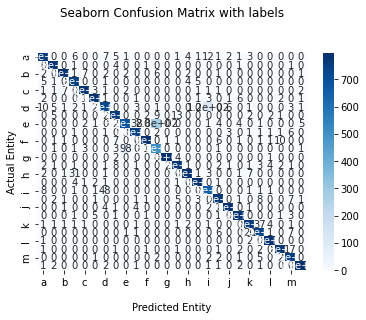

In [37]:
ax = sns.heatmap(confusion_matrix(prediction, y_test), annot=True, cmap='Blues')

ax.set_title(f'Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Entity')
ax.set_ylabel('Actual Entity')
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['a', 'b', 'c', 'd', 'e' ,'f' ,'g' ,'h' ,'i','j','k','l','m','n','o','b','q','r','s','t','u','v','w','x','y','z'])
ax.yaxis.set_ticklabels(['a', 'b', 'c', 'd', 'e' ,'f' ,'g' ,'h' ,'i','j','k','l','m','n','o','b','q','r','s','t','u','v','w','x','y','z'])
# Display the visualization of the Confusion Matrix.
plt.show()

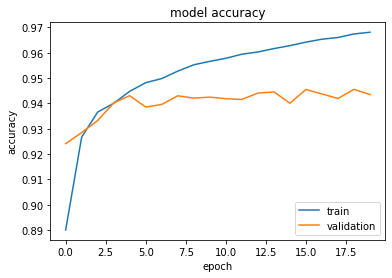

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

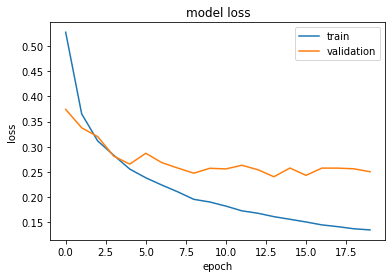

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()